<a href="https://colab.research.google.com/github/KOHEITERAO/diveintocode-ml/blob/master/sprint24_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KerasのRecurrentレイヤー
Kerasには複数のRecurrentレイヤーが用意されています。今回のSprintではこれら全てを動かし、それらを理解し区別できる状態を目指します。

以下のドキュメントにまとめられています。

Recurrentレイヤー - Keras Documentation

次の11個の項目があります。

* RNN
* SimpleRNN
* GRU
* LSTM
* ConvLSTM2D
* SimpleRNNCell
* GRUCell
* LSTMCell
* StackedRNNCells
* CuDNNGRU
* CuDNNLSTM


# 【問題1】各種手法の実行
Keras公式のサンプルをスタートコードとします。これを元に、上記11個の項目全てを使用してください。

例えばこの中でSimpleRNNとLSTMなどは並列関係であり、精度の比較が行えます。そういった関係を見つけて比較をしてください。

なおConvLSTM2Dのみ2次元配列を受け付ける手法であり、他と単純な精度の比較はできません。

LSTMのサンプルコード

keras/imdb_lstm.py at master · keras-team/keras

ConvLSTM2Dのサンプルコード

keras/conv_lstm.py at master · keras-team/keras

このサンプルコードをそのまま使う必要はなく、  
ノード数やエポックなどは変更して構いません。全て実行する上での実行時間を考慮した数に設定してください。

#### 最初に必要なライブラリをインポート

In [0]:
import keras
from keras.layers.core import Reshape, RepeatVector, Permute, Dense, Activation
from keras.layers.merge import Multiply, Add, Concatenate
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Lambda
from keras import backend as K

#### 必要なデータ等の前準備を行う

In [0]:
from __future__ import print_function
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.datasets import imdb
import numpy as np

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

############################################
# allow_pickle=True の問題を起こさないために追加
############################################
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# restore np.load for future normal usage
np.load = np_load_old
############################################

print('Loading data...')

print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

### RNNを実装

In [0]:
from keras.layers import RNN

In [0]:
class MinimalRNNCell(keras.layers.Layer):

    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        super(MinimalRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer='uniform',
            name='recurrent_kernel')
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        h = K.dot(inputs, self.kernel)
        output = h + K.dot(prev_output, self.recurrent_kernel)
        return output, [output]

# Let's use this cell in a RNN layer:

cell = MinimalRNNCell(32)
#x = keras.Input((None, 5))
#layer = RNN(cell)
#y = layer(x)

"""
# Here's how to use the cell to build a stacked RNN:

cells = [MinimalRNNCell(32), MinimalRNNCell(64)]
x = keras.Input((None, 5))
layer = RNN(cells)
y = layer(x)
"""
cell

In [0]:
############################################
# RNNに変更　#　RNNの１つ目の引数をcellに変更
############################################
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(RNN(cell))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=3,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 35s 1ms/step - loss: 0.4662 - acc: 0.7672 - val_loss: 0.4069 - val_acc: 0.8284
Epoch 2/3
25000/25000 [==============================] - 31s 1ms/step - loss: 0.2769 - acc: 0.8880 - val_loss: 0.4553 - val_acc: 0.8139
Epoch 3/3
25000/25000 [==============================] - 6s 223us/step
Test score: 0.48715485373020173
Test accuracy: 0.81696


### SimpleRNNを実装

In [0]:
#層のクラスをインポート
from keras.layers import SimpleRNN

############################################
# SimpleRNNに変更
############################################
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=3,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 51s 2ms/step - loss: 0.6897 - acc: 0.5393 - val_loss: 0.6555 - val_acc: 0.6077
Epoch 2/3
25000/25000 [==============================] - 47s 2ms/step - loss: 0.5573 - acc: 0.7093 - val_loss: 0.5222 - val_acc: 0.7571
Epoch 3/3
25000/25000 [==============================] - 8s 318us/step
Test score: 0.5156316001033783
Test accuracy: 0.752


### GRUを実装

In [0]:
#層のクラスをインポート
from keras.layers import GRU

############################################
# SimpleRNNに変更
############################################
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=3,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 133s 5ms/step - loss: 0.4683 - acc: 0.7734 - val_loss: 0.3754 - val_acc: 0.8360
Epoch 2/3
25000/25000 [==============================] - 127s 5ms/step - loss: 0.2771 - acc: 0.8872 - val_loss: 0.3887 - val_acc: 0.8329
Epoch 3/3
25000/25000 [==============================] - 23s 922us/step
Test score: 0.41361671339035033
Test accuracy: 0.83956


### LSTMを実装　#サンプルコードをそのまま実行

In [0]:
'''
#Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
**Notes**
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''

from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
import numpy as np

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

############################################
# allow_pickle=True の問題を起こさないために追加
############################################
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# restore np.load for future normal usage
np.load = np_load_old
############################################

print('Loading data...')

print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=3,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Using TensorFlow backend.


17465344/17464789 [==============================] - 1s 0us/step
Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)


W0627 04:14:20.689201 140712918361984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0627 04:14:20.720693 140712918361984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 04:14:20.727603 140712918361984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0627 04:14:20.879083 140712918361984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...


W0627 04:14:20.897521 140712918361984 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0627 04:14:21.189680 140712918361984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0627 04:14:21.215983 140712918361984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0627 04:14:21.222885 140712918361984 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapp

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 147s 6ms/step - loss: 0.4622 - acc: 0.7828 - val_loss: 0.3938 - val_acc: 0.8255
Epoch 2/3
25000/25000 [==============================] - 149s 6ms/step - loss: 0.3056 - acc: 0.8752 - val_loss: 0.3722 - val_acc: 0.8383
Epoch 3/3
25000/25000 [==============================] - 21s 822us/step
Test score: 0.4261469538974762
Test accuracy: 0.83276


### ConvLSTM2Dを実装　#この部分だけ他のコードとは異なるサンプルコードを利用

Train on 950 samples, validate on 50 samples
Epoch 1/5
950/950 [==============================] - 122s 129ms/step - loss: 0.2683 - val_loss: 0.0654
Epoch 2/5
950/950 [==============================] - 115s 121ms/step - loss: 0.0266 - val_loss: 0.0162
Epoch 3/5
950/950 [==============================] - 115s 121ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 4/5
950/950 [==============================] - 115s 121ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 5/5
950/950 [==============================] - 115s 121ms/step - loss: 7.5978e-04 - val_loss: 9.6950e-04


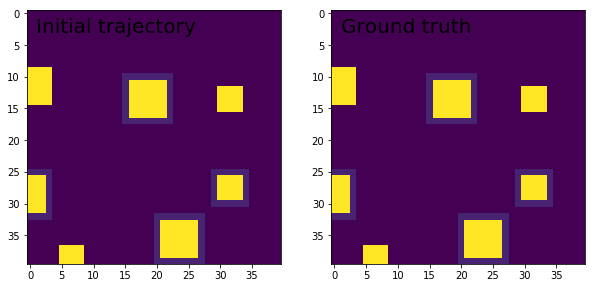

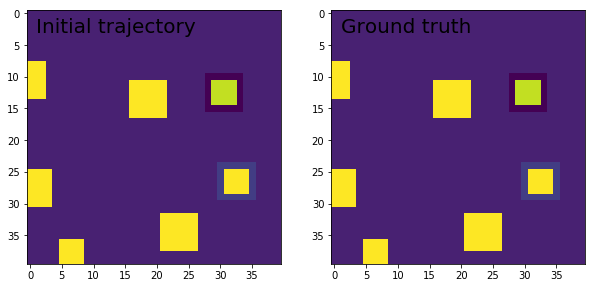

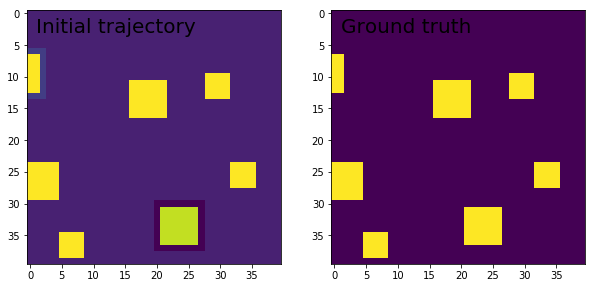

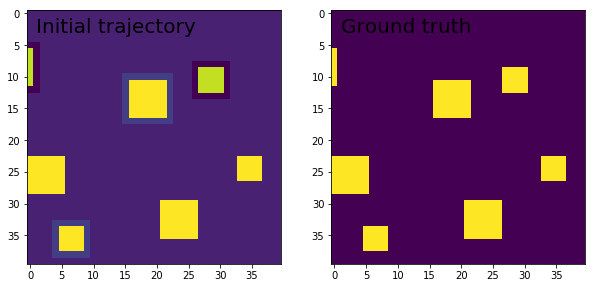

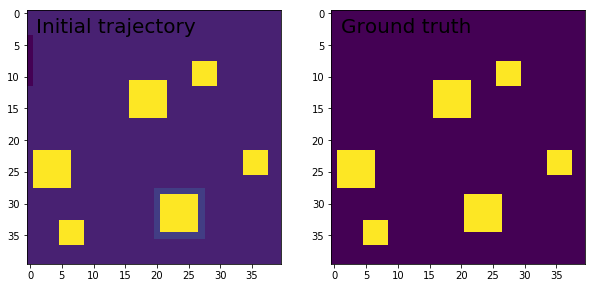

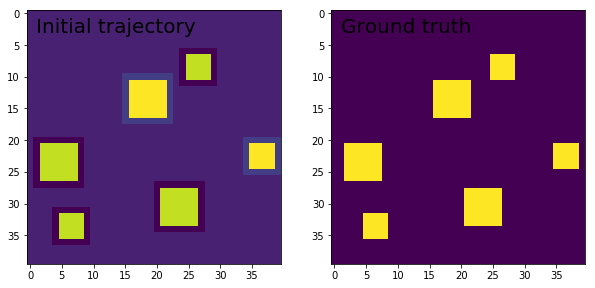

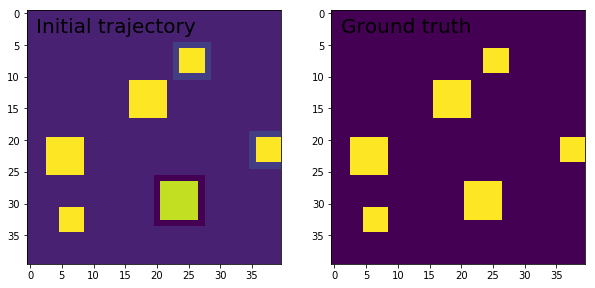

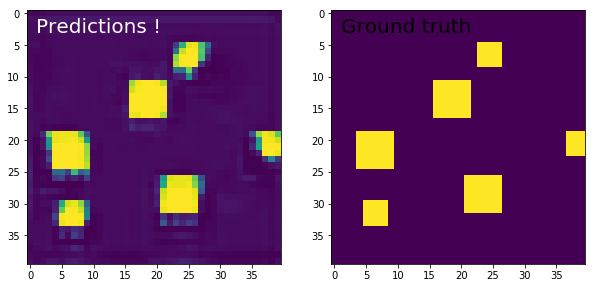

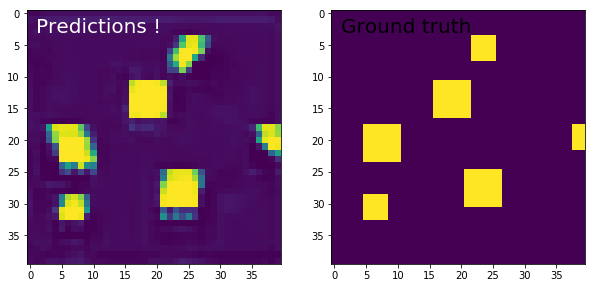

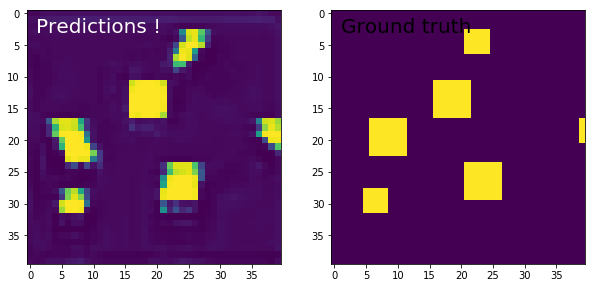

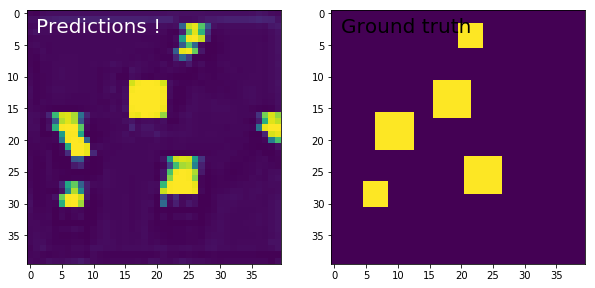

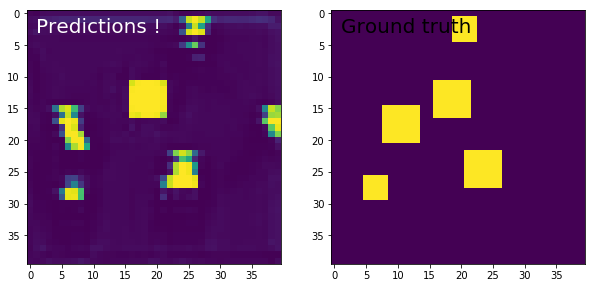

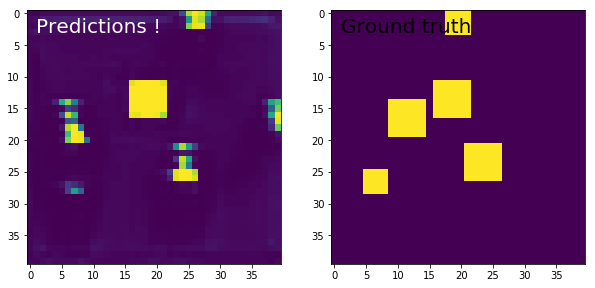

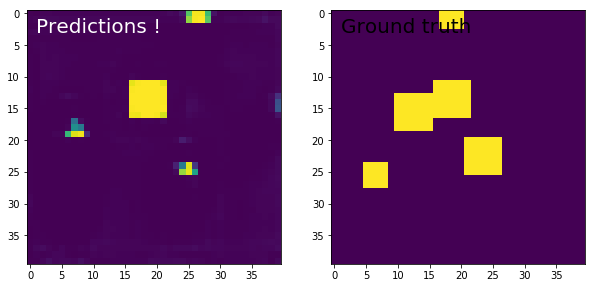

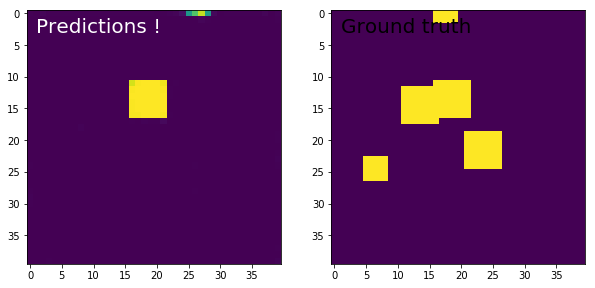

In [0]:
"""
#This script demonstrates the use of a convolutional LSTM network.
This network is used to predict the next frame of an artificially
generated movie which contains moving squares.
"""
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt

# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(None, 40, 40, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')


# Artificial data generation:
# Generate movies with 3 to 7 moving squares inside.
# The squares are of shape 1x1 or 2x2 pixels,
# which move linearly over time.
# For convenience we first create movies with bigger width and height (80x80)
# and at the end we select a 40x40 window.

def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

# Train the network
noisy_movies, shifted_movies = generate_movies(n_samples=1200)
seq.fit(noisy_movies[:1000], shifted_movies[:1000], batch_size=10,
        epochs=5, validation_split=0.05)

# Testing the network on one movie
# feed it with the first 7 positions and then
# predict the new positions
which = 1004
track = noisy_movies[which][:7, ::, ::, ::]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)


# And then compare the predictions
# to the ground truth
track2 = noisy_movies[which][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[which][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    plt.savefig('%i_animate.png' % (i + 1))

### SimpleRNNCellを実装

In [0]:
#層のクラスをインポート
from keras.layers import SimpleRNNCell

# SimpleRNNCellのインスタンスを作成
cell_simple_rnn = SimpleRNNCell(128)

############################################
# SimpleRNNCellに変更
############################################
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(RNN(cell_simple_rnn)) #基底になるRNNの引数にcellを入れる
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=3,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 45s 2ms/step - loss: 0.6330 - acc: 0.6194 - val_loss: 0.5855 - val_acc: 0.6985
Epoch 2/3
25000/25000 [==============================] - 41s 2ms/step - loss: 0.4708 - acc: 0.7776 - val_loss: 0.4736 - val_acc: 0.7900
Epoch 3/3
25000/25000 [==============================] - 7s 279us/step
Test score: 0.4541937585449219
Test accuracy: 0.7936


### GRUCellを実装

In [0]:
#層のクラスをインポート
from keras.layers import GRUCell

# GRUCellのインスタンスを作成
cell_gru_rnn = GRUCell(128, dropout=0.2, recurrent_dropout=0.2)

############################################
# GRUCellに変更
############################################
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(RNN(cell_gru_rnn )) #変更
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=3,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 139s 6ms/step - loss: 0.4728 - acc: 0.7729 - val_loss: 0.4254 - val_acc: 0.8103
Epoch 2/3
25000/25000 [==============================] - 134s 5ms/step - loss: 0.2914 - acc: 0.8822 - val_loss: 0.3714 - val_acc: 0.8446
Epoch 3/3
25000/25000 [==============================] - 23s 934us/step
Test score: 0.3907018481254578
Test accuracy: 0.83652


### LSTMCellを実装

In [0]:
#層のクラスをインポート
from keras.layers import LSTMCell

# LSTMCellのインスタンスを作成
cell_lstm_rnn = LSTMCell(128, dropout=0.2, recurrent_dropout=0.2)

############################################
# LSTMCellに変更
############################################
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(RNN(cell_lstm_rnn)) #変更
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=3,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 171s 7ms/step - loss: 0.4536 - acc: 0.7863 - val_loss: 0.4009 - val_acc: 0.8178
Epoch 2/3
25000/25000 [==============================] - 163s 7ms/step - loss: 0.2966 - acc: 0.8791 - val_loss: 0.3769 - val_acc: 0.8334
Epoch 3/3
25000/25000 [==============================] - 29s 1ms/step
Test score: 0.4897028240966797
Test accuracy: 0.82864


### StackedRNNCellsを実装

In [0]:
#層のクラスをインポート
from keras.layers import StackedRNNCells



stacked_rnn_cells = [MinimalRNNCell(32), MinimalRNNCell(64)]



############################################
# StackedRNNCellsに変更
############################################
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(RNN(stacked_rnn_cells)) #変更
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=3,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 56s 2ms/step - loss: 0.4950 - acc: 0.7502 - val_loss: 0.4065 - val_acc: 0.8158
Epoch 2/3
25000/25000 [==============================] - 50s 2ms/step - loss: 0.3186 - acc: 0.8632 - val_loss: 0.4727 - val_acc: 0.7743
Epoch 3/3
25000/25000 [==============================] - 8s 332us/step
Test score: 0.4346396702289581
Test accuracy: 0.81392


### CuDNNGRUを実装

In [0]:
#層のクラスをインポート
from keras.layers import CuDNNGRU

############################################
# SimpleRNNに変更
############################################
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(CuDNNGRU(128))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=3,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 30s 1ms/step - loss: 0.4408 - acc: 0.7847 - val_loss: 0.3507 - val_acc: 0.8465
Epoch 2/3
25000/25000 [==============================] - 25s 1ms/step - loss: 0.2401 - acc: 0.9043 - val_loss: 0.3638 - val_acc: 0.8410
Epoch 3/3
25000/25000 [==============================] - 6s 232us/step
Test score: 0.46447244542121885
Test accuracy: 0.83572


### CuDNNLSTMを実装

In [0]:
#層のクラスをインポート
from keras.layers import CuDNNLSTM

############################################
# SimpleRNNに変更
############################################
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(CuDNNLSTM(128))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=3,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 29s 1ms/step - loss: 0.4288 - acc: 0.7972 - val_loss: 0.3574 - val_acc: 0.8416
Epoch 2/3
25000/25000 [==============================] - 24s 976us/step - loss: 0.2519 - acc: 0.9000 - val_loss: 0.3796 - val_acc: 0.8354
Epoch 3/3
25000/25000 [==============================] - 6s 232us/step
Test score: 0.4452444035577774
Test accuracy: 0.83024


# 【問題2】比較結果の説明
11の項目それぞれがどういうものなのかを説明してください。また、比較した結果を表やグラフで載せ、説明してください。今回は「RNNはそれほど詳しくないがタスクで必要になったためKerasのドキュメントを見た」という仮定を置きます。

In [0]:
import pandas as pd
model_list = ['RNN', 'SimpleRNN', 'GRU', 'LSTM', 'SimpleRNNCell', 'GRUCell', 'LSTMCell', 'StackedRNNCells', 'CuDNNGRU', 'CuDNNLSTM']
score_list = [0.81696, 0.752, 0.83956, 0.83276, 0.7936, 0.83652, 0.82864, 0.81392, 0.83572, 0.83024]

df_accuracy_comparison = pd.DataFrame([score_list], index= ['accuracy score'], columns=model_list)
display(df_accuracy_comparison )

,RNN,SimpleRNN,GRU,LSTM,SimpleRNNCell,GRUCell,LSTMCell,StackedRNNCells,CuDNNGRU,CuDNNLSTM
accuracy score,0.81696,0.752,0.83956,0.83276,0.7936,0.83652,0.82864,0.81392,0.83572,0.83024


#### ＜比較＞
SimpleRNN, SimpleRNNCell,StackedRNNCells,RNNのスコアが相対的にやや低く出ているが、他のモデルのスコアは概ね８３％程度で安定している。

# 【問題3】（アドバンス課題）複数のデータセット間での比較
単一のデータセットでの実験に留めず、他のデータセットでも実験してみます。  
データセット - Keras Documentation  
Kerasで簡単に利用できる自然言語データセットとしてロイターのニュースワイヤー トピックス分類があります。  
IMDBは2値分類であったが、こちらは46値分類の問題です。

※未完